In [94]:
import pandas_datareader.data as web
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [96]:
df = pd.read_csv('/Users/kata/Desktop/GitHub/standby_duty_forecasting/sickness_table.csv', index_col=0)
df.head()

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2016-04-03,68,8088.0,1700,90,0.0,0.0
3,2016-04-04,71,7044.0,1700,90,0.0,0.0
4,2016-04-05,63,7236.0,1700,90,0.0,0.0


# Mean Squared Error Model

Calculate the MSE for the exising practice with 90 standby drivers by default.

In [97]:
def calc_mse(column1, column2):
    '''column1 is the default drivers
    column2 the needed ones'''
    mse_total = []
    for row in column1:
        mse = (column1 - column2)**2
    mse_total.append(mse)
    return sum(mse_total)


In [98]:
(calc_mse(df.n_sby, df.sby_need)).sum()

10830732.0

The mean squared error for the existing method is 10830732.0

# Linear Regression for comparison

In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [100]:
model = LinearRegression()

In [101]:
# train test split
X = df.sby_need.values.reshape(-1,1)
y = df.index
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .8)


In [102]:
model.fit(X, y)

LinearRegression()

In [103]:
pred = model.predict(X)

df['y_predicted'] = pred

In [104]:
# slope of the line
b = model.coef_

In [105]:
# intercept of the line
m = model.intercept_

In [123]:
# calculate mse
from sklearn.metrics import mean_squared_error, r2_score

In [130]:
# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(df['sby_need'], df['y_predicted']))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(df['sby_need'], df['y_predicted']))


Coefficients: 
 [0.57419653]
Mean squared error: 293594.88
Coefficient of determination: -45.27


In [132]:
# visualize
import matplotlib.pyplot as plt

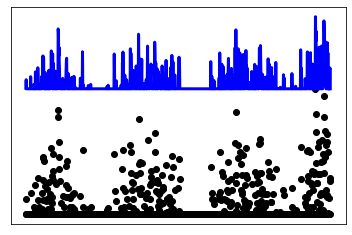

In [131]:


# Plot outputs
plt.scatter(df.date, df.sby_need, color="black")
plt.plot(df.date, pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

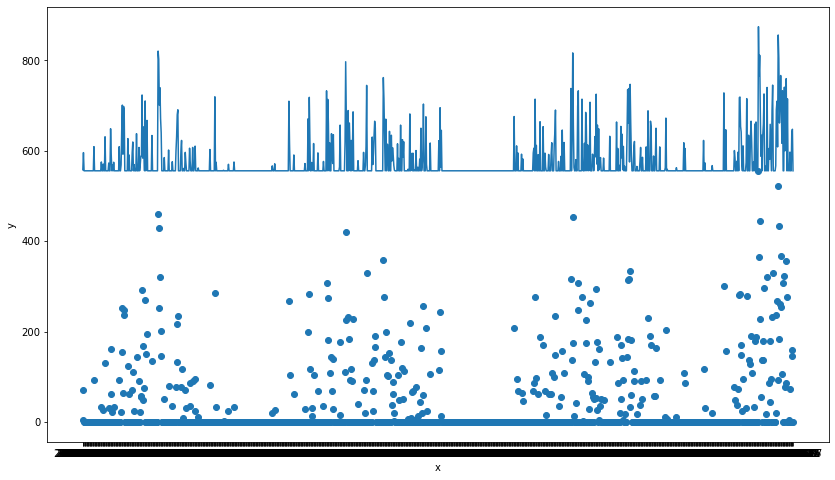

In [135]:
# plot the results
plt.figure(figsize=(14, 8))
ax = plt.axes()
ax.scatter(df.date, y)
ax.plot(df.date, pred)

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.axis('tight')


plt.show()